# L8d: Let's Implement a Cross Validation Algorithm for Ridge Regression
In this lab, we'll explore the how to estimate the optimal regularization parameter for Ridge Regression using cross-validation. Ridge Regression is a type of linear regression that includes a regularization term to prevent overfitting by penalizing large coefficients.

> __Learning Objectives:__
> 
> By the end of this lab, you will be able to:
> Three learning objectives here

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on Julia functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include-solution.jl"));

In addition to standard Julia libraries, we'll use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material. 

### Data
Let's generate some synthetic data that we'll use to train and validate our Ridge Regression model. We'll create a dataset with a known linear relationship and add some noise to it.

Fill me in. 

In [2]:
D = let

    # initialize -
    number_of_features = 6; # number of features
    number_of_levels = 4; # number of levels per feature
    max_number_of_samples = number_of_levels^number_of_features;
    D = zeros(max_number_of_samples, number_of_features);
    
    # Generate all combinations of features
    base = number_of_levels; # base for number system
    for i in 1:max_number_of_samples
        digits_i = digits(i-1, base=base, pad=number_of_features); # Oooh. This is kind of cool.
        D[i, :] = digits_i; # store the digits    
    end

    D .+= 1 # shift to 1-based min levels
end;

Fill me in

In [3]:
D

4096×6 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0
 2.0  1.0  1.0  1.0  1.0  1.0
 3.0  1.0  1.0  1.0  1.0  1.0
 4.0  1.0  1.0  1.0  1.0  1.0
 1.0  2.0  1.0  1.0  1.0  1.0
 2.0  2.0  1.0  1.0  1.0  1.0
 3.0  2.0  1.0  1.0  1.0  1.0
 4.0  2.0  1.0  1.0  1.0  1.0
 1.0  3.0  1.0  1.0  1.0  1.0
 2.0  3.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮
 4.0  2.0  4.0  4.0  4.0  4.0
 1.0  3.0  4.0  4.0  4.0  4.0
 2.0  3.0  4.0  4.0  4.0  4.0
 3.0  3.0  4.0  4.0  4.0  4.0
 4.0  3.0  4.0  4.0  4.0  4.0
 1.0  4.0  4.0  4.0  4.0  4.0
 2.0  4.0  4.0  4.0  4.0  4.0
 3.0  4.0  4.0  4.0  4.0  4.0
 4.0  4.0  4.0  4.0  4.0  4.0

In [4]:
digits(1, base=4, pad=3) .+= 1

3-element Vector{Int64}:
 2
 1
 1

Fill me in

In [5]:
α,γ = let
    
    # initialize -
    α = 2.0; # intercept
    number_of_features = size(D, 2);
    γ = randn(number_of_features); # coefficients

    (α,γ)
end

(2.0, [-0.454918834817106, 0.11844432446196011, 0.22041226967397523, 0.7494217945598631, -1.7738525403014207, 0.16230513220856874])

Fill me in.

In [6]:
ŷ = let

    # initialize -
    number_of_samples = size(D, 1);
    ŷ = zeros(number_of_samples);
    noise_level = 0.0;
    ϵ = Normal(0, noise_level); # noise distribution
    
    # Generate response with some noise
    for i in 1:number_of_samples
        ŷ[i] = log(α) + dot(γ, log.(D[i, :])) + rand(ϵ); # linear model with noise
    end

    ŷ;
end

4096-element Vector{Float64}:
  0.6931471805599453
  0.3778214728228528
  0.19336775828329467
  0.06249576508576027
  0.7752465301140803
  0.4599208223769878
  0.27546710783742967
  0.14459511463989527
  0.8232715709368474
  0.507945863199755
  ⋮
 -0.7450084754072447
 -0.0663320191102924
 -0.3816577268473852
 -0.5661114413869431
 -0.6969834345844775
 -0.032257710378924664
 -0.34758341811601723
 -0.5320371326555754
 -0.6629091258531098

Finally, let's partition the data into a `training` and `testing` set so that we can determine how well the model can predict unseen data, i.e., how well the model generalizes.

In [7]:
training, testing = let

    # initialize -
    s = 0.80; # fraction of data for training
    number_of_training_samples = Int(s * size(D,1) |> floor); # 80% of the data for training
    i = randperm(size(D,1)); # random permutation of the indices
    training_indices = i[1:number_of_training_samples]; # first 80% of the indices
    testing_indices = i[number_of_training_samples+1:end]; # last 20% of
    
    # setup training -
    one_vector = ones(number_of_training_samples);
    training = (X = [D[training_indices, :] one_vector], y = ŷ[training_indices]);

    # setup testing -
    one_vector = ones(length(testing_indices));
    testing = (X = [D[testing_indices, :] one_vector], y = ŷ[testing_indices]);

    training, testing;
end;

In [8]:
testing.X

820×7 Matrix{Float64}:
 1.0  4.0  3.0  1.0  2.0  2.0  1.0
 2.0  1.0  4.0  3.0  4.0  3.0  1.0
 2.0  2.0  1.0  4.0  3.0  2.0  1.0
 4.0  4.0  1.0  1.0  2.0  3.0  1.0
 1.0  3.0  1.0  3.0  2.0  4.0  1.0
 2.0  3.0  2.0  3.0  4.0  1.0  1.0
 3.0  4.0  3.0  1.0  1.0  4.0  1.0
 2.0  3.0  2.0  1.0  4.0  3.0  1.0
 1.0  4.0  3.0  2.0  3.0  4.0  1.0
 2.0  4.0  2.0  1.0  3.0  3.0  1.0
 ⋮                        ⋮    
 4.0  4.0  1.0  2.0  3.0  4.0  1.0
 4.0  2.0  2.0  4.0  3.0  3.0  1.0
 2.0  1.0  2.0  1.0  2.0  4.0  1.0
 1.0  2.0  3.0  3.0  3.0  2.0  1.0
 1.0  1.0  4.0  4.0  3.0  2.0  1.0
 2.0  2.0  2.0  1.0  2.0  2.0  1.0
 1.0  2.0  2.0  2.0  1.0  2.0  1.0
 3.0  1.0  1.0  3.0  3.0  2.0  1.0
 4.0  2.0  2.0  1.0  2.0  1.0  1.0

___

## Task 2: Estimate model parameters with regularization and SVD
In this task, we'll estimate the utility model parameters directly, and using Singular Value Decomposition (SVD) with regularization.

There are several types of regularization techniques, but we will focus on __Ridge regression__ (also known as Tikhonov regularization or L2 regularization). The ridge regression problem is given by:
$$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} = \arg\min_{\mathbf{\theta}}\left( \frac{1}{2}\;\lVert~\mathbf{y} - \hat{\mathbf{X}}\;\mathbf{\theta}~\rVert^{2}_{2} + \frac{\delta}{2}\;\lVert~\mathbf{\theta}~\rVert^{2}_{2}\right)
\end{align*}
$$
where $\delta\geq 0$ is the regularization parameter controlling regularization strength. The first term measures the sum of squared errors, while the second term penalizes large parameter values. The analytical solution for the optimal parameters is given by:
$$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} &= \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}} + \delta\;\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}
\end{align*}
$$

Let's start by setting the regularization parameter `δ::Float64`.

In [9]:
δ = 0.0; # regularization parameter

Next, let's compute the model parameters directly using the ridge regression formula above. We'll save the model parameters in the `θ̂₂::Vector{Float64}` variable.

In [10]:
θ̂ = let

    # initialize -
    X = training.X;
    y = training.y;
    p = size(X,2); # number of parameters

    # compute the ridge regression parameters -
    θ_ridge = inv(transpose(X)*X + δ*I(p))*transpose(X)*y;
    θ_ridge; # return
end;

Fill me in

In [11]:
let 
    
    # initialize -
    df = DataFrame();
    number_of_parameters = length(θ̂);

    # build true parameter vector array -
    θ_true = vcat(γ, log(α));

    # fill the data frame -
    for i ∈ 1:number_of_parameters
        row_df = (
            Parameter = "θ[$i]",
            True = θ_true[i],
            Estimated = θ̂[i],
            Error = θ̂[i] - θ_true[i],
            RelativeErrorPercent = 100 * (θ̂[i] - θ_true[i]) / θ_true[i]
        );
        push!(df, row_df);
    end

    pretty_table(
         df;
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );


end

 ----------- ----------- ----------- ------------ ----------------------
  Parameter        True   Estimated        Error   RelativeErrorPercent 
     String     Float64     Float64      Float64                Float64 
 ----------- ----------- ----------- ------------ ----------------------
       θ[1]   -0.454919   -0.207504     0.247414               -54.3865
       θ[2]    0.118444   0.0560975   -0.0623468               -52.6381
       θ[3]    0.220412    0.101518    -0.118894               -53.9416
       θ[4]    0.749422    0.339767    -0.409654               -54.6627
       θ[5]    -1.77385   -0.808906     0.964947               -54.3984
       θ[6]    0.162305   0.0757079   -0.0865973               -53.3546
       θ[7]    0.693147     1.02476     0.331609                47.8411
 ----------- ----------- ----------- ------------ ----------------------


Fill me in

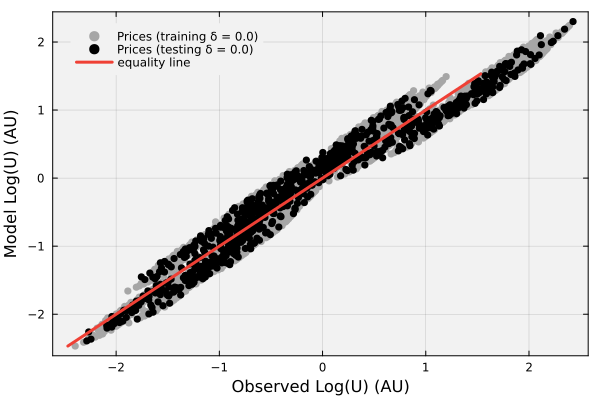

In [ ]:
let

    # initialize -
    p = vcat(γ, log(α));
    predicted_training_y_reg = training.X * p; # predicted output for the training data
    predicted_testing_y_reg = testing.X * p; # predicted output for the testing data

    # initialize -
    y_train = training.y;
    ŷ_train = predicted_training_y_reg;
    y_test = testing.y;
    ŷ_test = predicted_testing_y_reg;

    # plot -
    xy_line = min(minimum(ŷ_train), minimum(y_train)):1:max(maximum(y_train),maximum(ŷ_train)) |> collect;
    scatter(y_train,ŷ_train,label="Prices (training δ = $(δ))",c=:gray65, msc=:gray65)
    scatter!(y_test,ŷ_test,label="Prices (testing δ = $(δ))",c=:black, msc=:black)
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035")

    xlabel!("Observed Log(U) (AU)", fontsize=18)
    ylabel!("Model Log(U) (AU)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end